Imports

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import mixed_precision

2023-10-24 12:46:29.568597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 12:46:29.568683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 12:46:29.587970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 12:46:32.244719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2023-10-24 12:47:42.367740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:42.955764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:42.955830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Sizes

In [3]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/PlantVillage",
                                                   shuffle=True,
                                                   image_size = (Image_size,Image_size),
                                                   batch_size = Batch_size)

Found 10687 files belonging to 9 classes.


2023-10-24 12:47:57.845574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:57.845641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:57.845659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:58.181093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 12:47:58.181155: I tensorflow/compile

In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

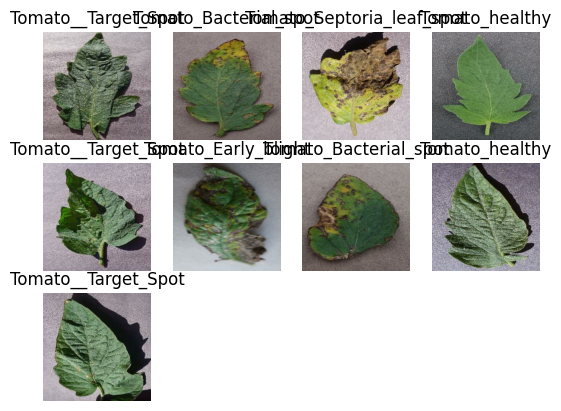

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_dataset = dataset.take(int(len(dataset)*0.8))
test_dataset = dataset.skip(len(train_dataset))
val_dataset = test_dataset.take(int(len(dataset)*0.1))
test_dataset = test_dataset.skip(len(val_dataset))

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=100):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    train_dataset = ds.take(train_size)
    val_dataset=ds.skip(train_size).take(val_size)
    test_dataset=ds.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset,test_dataset,val_dataset = get_dataset_partitions_tf(dataset)

In [10]:
train_dataset=train_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation=  resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (Batch_size,Image_size,Image_size, Channels)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), padding="same", activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 61, 61, 32)         

In [15]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=1e-7, min_delta=0.0004, mode='min')
early_stopping=EarlyStopping(monitor='val_loss', patience=5,start_from_epoch=3,restore_best_weights=True)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [17]:
history = model.fit(
    train_dataset,
    epochs=Epochs,
    batch_size  = Batch_size,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1,
    validation_data=val_dataset
)

Epoch 1/50


2023-10-24 12:48:12.395117: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-10-24 12:48:12.481810: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-10-24 12:48:13.314539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-24 12:48:16.783288: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-24 12:48:18.805259: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilat

266/267 [============================>.] - ETA: 0s - loss: 2.0219 - accuracy: 0.4035

2023-10-24 12:48:44.469596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:26: Filling up shuffle buffer (this may take a while): 1 of 100
2023-10-24 12:48:44.469709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


267/267 [==============================] - 42s 78ms/step - loss: 2.0198 - accuracy: 0.4039 - val_loss: 1.4946 - val_accuracy: 0.5262 - lr: 1.0000e-04
Epoch 2/50
267/267 [==============================] - 6s 21ms/step - loss: 1.1511 - accuracy: 0.6257 - val_loss: 1.1390 - val_accuracy: 0.6099 - lr: 1.0000e-04
Epoch 3/50
267/267 [==============================] - 6s 21ms/step - loss: 0.8587 - accuracy: 0.7104 - val_loss: 0.9312 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 4/50
267/267 [==============================] - 6s 21ms/step - loss: 0.7171 - accuracy: 0.7578 - val_loss: 1.2991 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 5/50
267/267 [==============================] - 5s 19ms/step - loss: 0.6363 - accuracy: 0.7811 - val_loss: 0.8003 - val_accuracy: 0.7111 - lr: 1.0000e-04
Epoch 6/50
267/267 [==============================] - 5s 20ms/step - loss: 0.5745 - accuracy: 0.8018 - val_loss: 0.8126 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 7/50
267/267 [==============================

In [18]:
scores = model.evaluate(test_dataset)

2023-10-24 12:50:29.237384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 72 of 100
2023-10-24 12:50:29.242044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 73 of 100
2023-10-24 12:50:31.925307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-24 12:50:40.032454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 1 of 100
2023-10-24 12:50:40.033047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


33/33 [==============================] - 48s 37ms/step - loss: 0.7104 - accuracy: 0.7765


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

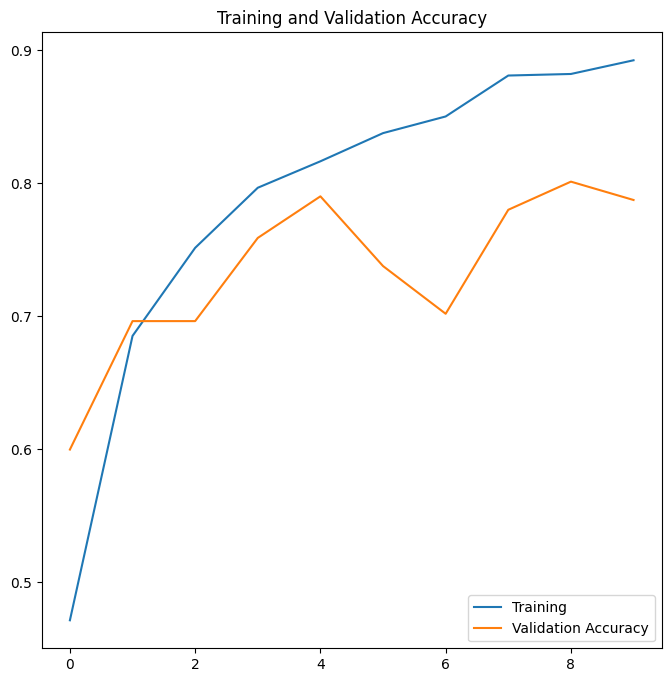

In [22]:
plt.figure(figsize=(8,8))
plt.plot(range(10), acc, label='Training')
plt.plot(range(10),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


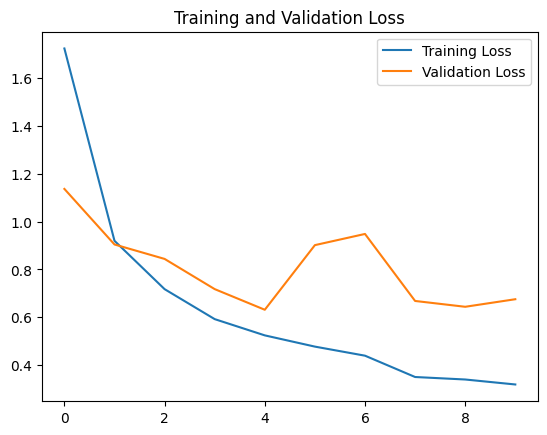

In [23]:
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.maxa(predictions[0])), 2)
    return predicted_class, confidence

In [25]:
model_version=2
model.save("Disease_model.h5")


/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import os
os.listdir()

['Disease_model.h5', 'test1', 'Untitled-1.ipynb']

In [21]:
import keras_tuner
from keras.models import Sequential
from keras import Input

Using TensorFlow backend


In [22]:


# def build_model(hp):
#     model = Sequential()
#     model.add(Input(shape=(Image_size, Image_size, 3)))
#     model.add(data_augmentation)
#     model.add(resize_and_rescale)
#     for i in range(hp.Int("num_layers", 3, 7, default=5)):
#         kernel1 = hp.Int(f"kernel _{i}alpha", min_value=1, max_value=5, step=2, default=1)
#         model.add(layers.Conv2D(hp.Int(f"units_{i}alpha", min_value=16, max_value=128, step=4, default=16), (kernel1,kernel1), padding="same", activation="relu"))
#         if hp.Boolean(f"Conv2D{i}beta"):
#             kernel2 = hp.Int(f"kernel_{i}beta", min_value=1, max_value=5, step=2, default=1)
#             model.add(layers.Conv2D(hp.Int(f"units_{i}beta", min_value=16, max_value=128, step=4, default=32), (kernel2,kernel2), padding="same", activation="relu"))
#         if hp.Boolean(f"Conv2D{i}gamma"):
#             kernel3 = hp.Int(f"kernel_{i}gamma", min_value=1, max_value=5, step=2, default=1)
#             model.add(layers.Conv2D(hp.Int(f"units_{i}gamma", min_value=16, max_value=128, step=4, default=64), (kernel3,kernel3), padding="same", activation="relu"))
#         if hp.Boolean(f"BatchNormalization{i}"):
#             model.add(layers.BatchNormalization())
#         model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Flatten()),
#     model.add(layers.Dense(hp.Int("dense1", min_value=32, max_value=1024, step=8, default=512), activation='relu'))
#     if hp.Boolean("Dropout1"):
#          model.add(layers.Dropout(hp.Float("Dropout1Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
#     model.add(layers.Dense(hp.Int("dense2", min_value=16, max_value=1024, step=8), activation='relu'))
#     if hp.Boolean("Dropout2"):
#          model.add(layers.Dropout(hp.Float("Dropout2Rt", min_value=0.1, max_value=0.8, step=0.05, default=0.3)))
#     model.add(layers.Dense(n_classes, activation='softmax'))
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#                metrics=['accuracy'])
#     return model

In [23]:

# build_model(keras_tuner.HyperParameters())
# tuner = keras_tuner.Hyperband(build_model,
# objective='val_accuracy',
# max_epochs=40,
# factor=3,
# directory='test1',
# project_name='vegetables'
# )
# early_stopping= EarlyStopping(monitor='val_loss', patience=10,start_from_epoch=3,restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=3, min_lr=1e-10, min_delta=0.0004, mode='min')
# tuner.search(train_dataset, epochs=50, validation_data=val_dataset, batch_size=Batch_size, use_multiprocessing = True, workers = 2, verbose=1, callbacks = [early_stopping, reduce_lr])
# models = tuner.get_best_models(num_models=5)
# model = models[0]
# for i in range(len(models)):
#     print(f"----------------------model{i}----------------------------")
#     print(models[i].summary())

Trial 80 Complete [00h 06m 24s]
val_accuracy: 0.7847285866737366

Best val_accuracy So Far: 0.9411223530769348
Total elapsed time: 00h 31m 07s
----------------------model0----------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      256       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                      

In [28]:
modelik = model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      256       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 100)     57700     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 36)      3

In [29]:
from tensorflow.keras.layers import Dropout, BatchNormalization

In [40]:
model = Sequential([
   resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(64,(3,3), padding="same", activation = 'relu', input_shape = input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(100,kernel_size = (3,3), activation = 'relu'),
    layers.Conv2D(36,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(68, (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(384,activation='relu'),
    layers.Dense(184,activation='relu') ,
    layers.Dense(n_classes,activation='softmax')
])

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [42]:
history = model.fit(
    train_dataset,
    epochs=100,
    batch_size  = 256,
    callbacks = [early_stopping, reduce_lr],
    verbose = 1,
    validation_data=val_dataset
)

Epoch 1/100


267/267 [==============================] - 20s 62ms/step - loss: 1.1601 - accuracy: 0.5990 - val_loss: 1.4321 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 2/100
267/267 [==============================] - 16s 62ms/step - loss: 0.6126 - accuracy: 0.7846 - val_loss: 1.1340 - val_accuracy: 0.6274 - lr: 1.0000e-04
Epoch 3/100
267/267 [==============================] - 16s 62ms/step - loss: 0.4494 - accuracy: 0.8421 - val_loss: 0.8760 - val_accuracy: 0.7286 - lr: 1.0000e-04
Epoch 4/100
267/267 [==============================] - 16s 61ms/step - loss: 0.3749 - accuracy: 0.8669 - val_loss: 1.0291 - val_accuracy: 0.7102 - lr: 1.0000e-04
Epoch 5/100
267/267 [==============================] - 16s 62ms/step - loss: 0.3256 - accuracy: 0.8821 - val_loss: 1.2753 - val_accuracy: 0.6440 - lr: 1.0000e-04
Epoch 6/100
267/267 [==============================] - 16s 61ms/step - loss: 0.2905 - accuracy: 0.8988 - val_loss: 0.8806 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 7/100
267/267 [===================

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

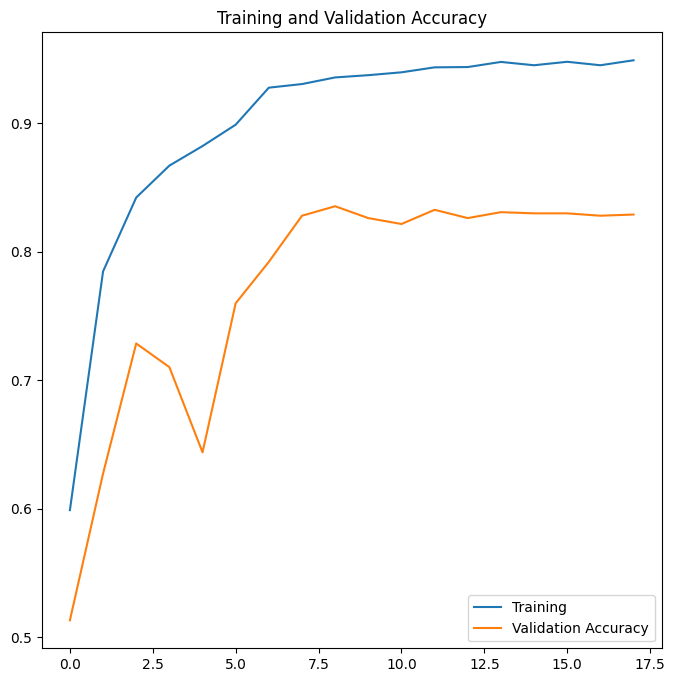

In [44]:
plt.figure(figsize=(8,8))
plt.plot(range(18), acc, label='Training')
plt.plot(range(18),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


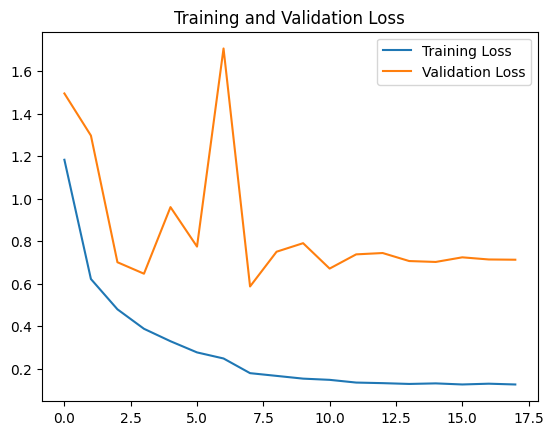

In [37]:
plt.plot(range(18), loss, label='Training Loss')
plt.plot(range(18),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.maxa(predictions[0])), 2)
    return predicted_class, confidence

In [45]:
model_version=2
model.save("Disease_model.h5")


/mnt/c/Users/Kamil/Desktop/PROGRAMMING/Rok4/ASI/JupyterASI/Asi/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
